In [45]:
import scipy #as sp
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from pathlib import Path
from tqdm.notebook import tqdm
import mplniw.utils as ut
import mplniw.sigp as sp

import gvpy as gv
# import osnap
import niskine

In [6]:
root_dir = '/Users/zcasparcohen/codes/NIW/'
data_dir = root_dir+'data/'
conf = niskine.io.load_config()

In [7]:
# Mooring location
m1lon, m1lat, m1bottom_depth = niskine.io.mooring_location(mooring=1)
m2lon, m2lat, m2bottom_depth = niskine.io.mooring_location(mooring=2)
m3lon, m3lat, m3bottom_depth = niskine.io.mooring_location(mooring=3)

In [23]:
# Wind dataset
mooring = 1
wind = xr.open_dataset(data_dir+'era5_uv_10m.nc')
mld_m1 = xr.open_dataarray(conf.data.ml.mld)
gridded = xr.open_dataset(data_dir+'M%s_linear_merge_slinearfill.nc'%mooring)[['u','v']]
ds_mld = gridded.where(gridded.z<mld_m1).mean('z')

In [32]:
s_w = 0.3
mlon,mlat = m1lon,m1lat
wind=wind.sel(lon=mlon,lat=mlat,method='nearest')
wind['u_ocean'] = ds_mld.u.interp_like(wind.u10)
wind['v_ocean'] = ds_mld.v.interp_like(wind.v10)
wind['u_wind_relative'] = wind.u10 - wind.u_ocean
wind['v_wind_relative'] = wind.v10 - wind.v_ocean
wind['taux'],wind['tauy'] = gv.ocean.wind_stress(wind.u_wind_relative,wind.v_wind_relative)

In [36]:
wind_stress = xr.open_dataset('/Users/zcasparcohen/codes/NIW/'+'data/wind_work/wind_stress_niskine_m1.nc')

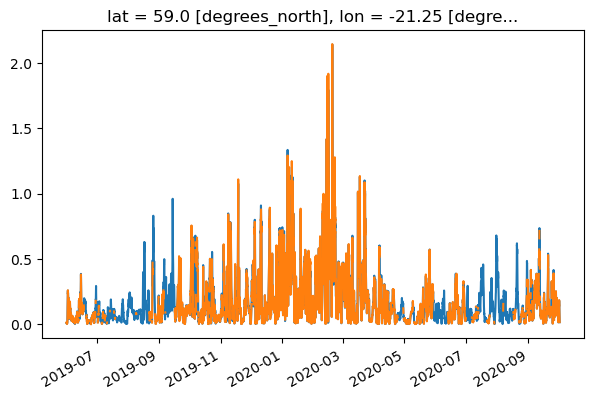

In [38]:
fig,ax = plt.subplots(figsize=(7,4))
wind_stress['__xarray_dataarray_variable__'].sel(time=slice('2019-06-01','2020-10-01')).plot(ax=ax)
np.sqrt(wind.taux**2+wind.tauy**2).sel(time=slice('2019-06-01','2020-10-01')).plot()


In [43]:
Tw = 30  # Kernel length
#omega = 2.0 
omega = ut.coriolis(mlat)*3600*24/(2*np.pi)  # Central frequency
#bandwidth = None 
bandwidth = 0.2
dt = 1/(24*6)  # Time step in days unit
h = ut.generate_filter(omega,dt=dt,T=Tw,bandwidth=bandwidth,lat=mlat,pass_zero=False)  # Best filter
h_hat, w = ut.filter_response(h, dt=dt)  #Filter response

In [49]:
ds = sp.wrap_filter(ds_mld,h,**{'hilbert':False})
wind_ni = sp.wrap_filter(wind,h,columns=['u_ocean','v_ocean','taux','tauy'],**{'hilbert':False})

In [56]:
wind_work = xr.open_dataset(data_dir+'ni_wind_work_niskine_m1.nc')
wind_ni['wind_work'] = wind_ni.taux_filtered * wind_ni.u_ocean_filtered + wind_ni.tauy_filtered * wind_ni.v_ocean_filtered

In [58]:
wind_work

<xarray.Dataset>
Dimensions:                        (time: 12160)
Coordinates:
  * time                           (time) datetime64[ns] 2019-05-17T17:00:00 ...
    lat                            float64 ...
    lon                            float64 ...
Data variables:
    __xarray_dataarray_variable__  (time) float64 ...

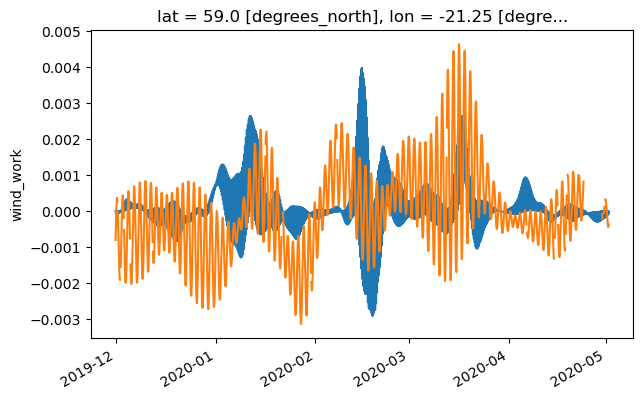

In [60]:
fig,ax = plt.subplots(figsize=(7,4))
wind_work['__xarray_dataarray_variable__'].sel(time=slice('2019-12-01','2020-05-01')).plot(ax=ax)
wind_ni.wind_work.sel(time=slice('2019-12-01','2020-05-01')).plot(ax=ax)


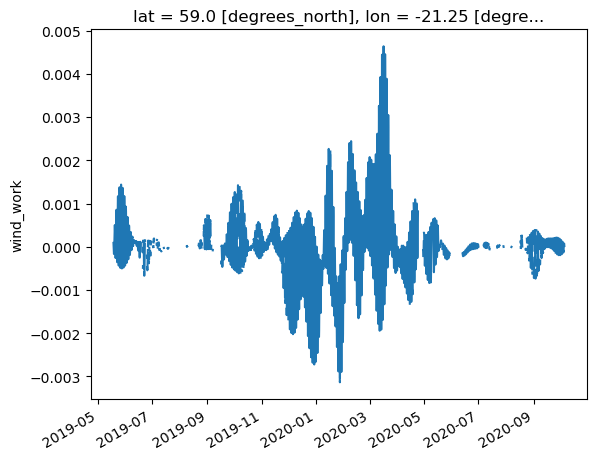

In [62]:
wind_ni.wind_work.plot()